# Active Learner
Using Parameters from Park, Lee & Moon  
Pool based, SVM, inductive -> those parameters are standard  
Initial set: Normally, k-means is used. PLM recommend their own algorithm, LCA.  
After all documents are labeled, the corpus becomes input to the Sentiment Lexicon Extraction Model (SLE-BE), which creates the domain-specific lexicon.

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_pickle("./data/cleaned_submissions.pkl")

In [4]:
text = data["text"]
labels = data["sentiment"]

# Get labeled instances
indices = []
for i in range(0, len(labels), 10):
    indices.append(i)
    
# Set seed
X_seed = text[indices]
y_seed = labels[indices]

In [5]:
# Get unlabeled instances
new_indices = []
for i in range(0, len(data["text"].index)):
    if i not in indices:
        new_indices.append(i)

In [6]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
y_train = lenc.fit_transform(y_seed)

# Vectorize text using tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=' '.join, lowercase=False, min_df=5) # min_df = Minimum occurance of words
X_train = tfidf.fit_transform(data["text"])

In [7]:
# Set aside test set, to better judge the performance of the AL. This is not done in the literature
from sklearn.model_selection import train_test_split

X_train_seed, X_test, y_train_seed, y_test = train_test_split(X_train[indices], y_train, test_size=0.2, random_state=10)

In [8]:
# y_train_seed = y_train # To feed the Active Leaner
# X_train_seed = X_train[indices] # To feed the Active Learner
X_train_pool = X_train[new_indices] # Instances that need to be labeled

/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/stefanwinter/Local/Thesis/App/.thesis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


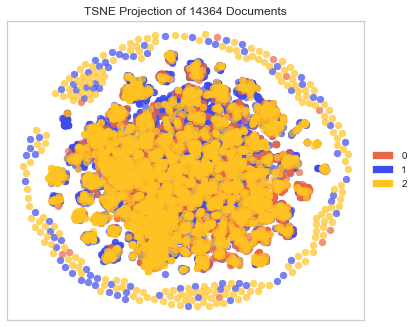

<AxesSubplot:title={'center':'TSNE Projection of 14364 Documents'}>

In [10]:
# Try to visualize seed via t-sne
# Playing with t-sne
# https://www.scikit-yb.org/en/latest/api/text/tsne.html
# https://www.districtdatalabs.com/text-analytics-with-yellowbrick

from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(decompose_by = 100, alpha = 0.7, colors = ["#E96744", "#3F4CEC", "#FFC322"], labels = ["bearish", "bullish", "neutral"], random_state = 2)
tsne.fit_transform(X_train_seed, y_train_seed)
tsne.show(labels = ["bearish", "bullish", "neutral"])

In [11]:
print((X_train_seed[y_train_seed != 2].shape))
print((y_train_seed[y_train_seed != 2].shape))

(10242, 19267)
(10242,)


In [9]:
X_train_seed[y_train_seed != 2]
y_train_seed[y_train_seed != 2]

# Try to visualize seed via t-sne
# Playing with t-sne
# https://www.scikit-yb.org/en/latest/api/text/tsne.html
# https://www.districtdatalabs.com/text-analytics-with-yellowbrick

from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(decompose_by = 100, alpha = 0.7, colors = ["#E96744", "#3F4CEC", "#FFC322"], labels = ["bearish", "bullish", "neutral"], random_state = 2)
tsne.fit_transform(X_train_seed[y_train_seed != 2], y_train_seed[y_train_seed != 2])
tsne.show(labels = ["bearish", "bullish", "neutral"])

array([ True,  True,  True, ..., False,  True,  True])

In [11]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.svm import SVC

learner = ActiveLearner(
    estimator = SVC(probability=True),
    query_strategy = uncertainty_sampling,
    X_training = X_train_seed,
    y_training = y_train_seed
)

In [15]:
# Using Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# for sentence in data["text"][indices][:30]:
#     vs = analyzer.polarity_scores(" ".join(sentence))
#     print("{:} {}".format(" ".join(sentence), str(vs)))
#     print("-"*40)


def vader_sentiment_labels(query_text):
    sentiment_list = []
    for item in query_text:
        sentence = tfidf.inverse_transform(item)
        vs = analyzer.polarity_scores(" ".join(sentence[0]))
        if vs["compound"] > 0.05:
            sentiment_list.append(np.int(2)) # Positive Sentiment
        elif vs["compound"] < -0.05:
            sentiment_list.append(np.int(0)) # Negative Sentiment
        else:
            sentiment_list.append(np.int(1)) # Neutral Sentiment
    return sentiment_list

In [16]:
'''
Try to fix the following error by introducing some noise:
ValueError: The number of classes has to be greater than one; got 1 class
'''
def catch_value_error_for_svm(l):
    zeros, ones, twos = 0, 0, 0
    
    for item in l:
        if item == 0:
            zeros = zeros + 1
        elif item == 1:
            ones = ones + 1
        else:
            twos = twos + 1

    if zeros == len(l):
        l[0] = 1
    elif ones == len(l):
        l[0] = 2
    else:
        l[0] = 1

    return l

In [17]:
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

In [18]:
'''Confirm that the delete_rows_csr deletes the correct documents.'''
# DEV only
new_matrix = delete_rows_csr(X_train_pool[:6, :1000], [0, 2]) # Small subsample of the pool and delete the 0 and 2 indices
print(X_train_pool[:6, :1000])
print(new_matrix)

  (0, 748)	0.38369139324557416
  (1, 124)	0.052544837178480554
  (1, 123)	0.04775251455321511
  (1, 756)	0.057365758048549466
  (1, 769)	0.16724488582565328
  (1, 748)	0.12227571135467478
  (2, 421)	0.09574210720799499
  (2, 460)	0.08050868994299826
  (2, 178)	0.14251048953396778
  (3, 194)	0.1491133580521136
  (3, 122)	0.08896652884782236
  (3, 223)	0.1345514615580049
  (3, 756)	0.10088630943510701
  (3, 769)	0.14706263698778613
  (4, 945)	0.04471574632707342
  (5, 816)	0.06515606561607992
  (5, 702)	0.049442434403347356
  (5, 866)	0.07798167656963896
  (5, 744)	0.07366847080021538
  (5, 653)	0.09882634398749389
  (0, 124)	0.052544837178480554
  (0, 123)	0.04775251455321511
  (0, 756)	0.057365758048549466
  (0, 769)	0.16724488582565328
  (0, 748)	0.12227571135467478
  (1, 194)	0.1491133580521136
  (1, 122)	0.08896652884782236
  (1, 223)	0.1345514615580049
  (1, 756)	0.10088630943510701
  (1, 769)	0.14706263698778613
  (2, 945)	0.04471574632707342
  (3, 816)	0.06515606561607992
  (3, 7

In [20]:
accuracy_scores = [learner.score(X_test, y_test)]

# the active learning loop
n_queries = 20
for i in range(n_queries):
    print('Query no. %d' % (i + 1))
    query_idx, query_sample = learner.query(X_train_pool, n_instances=100)
    learner.teach(
        X=X_train_pool[query_idx], y=np.array(catch_value_error_for_svm(vader_sentiment_labels(query_sample))), only_new = False #True
    )
    # remove queried instance from pool
    X_train_pool = delete_rows_csr(X_train_pool, query_idx) # np.delete(X_train_pool, query_idx, axis = 0) -> For normal numpy arrays
    accuracy_scores.append(learner.score(X_test, y_test))

Query no. 1
Query no. 2
Query no. 3
Query no. 4
Query no. 5
Query no. 6
Query no. 7
Query no. 8
Query no. 9
Query no. 10
Query no. 11
Query no. 12
Query no. 13
Query no. 14
Query no. 15
Query no. 16
Query no. 17
Query no. 18
Query no. 19
Query no. 20


In [21]:
from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [33]:
# The accuracy drops after every iteration, I assume that is because I use VADER... Will be better when I act as the oracle
np.savetxt("./data/evaluation/AL_accuracy_scores.csv", accuracy_scores, delimiter = ",", fmt ='% s')

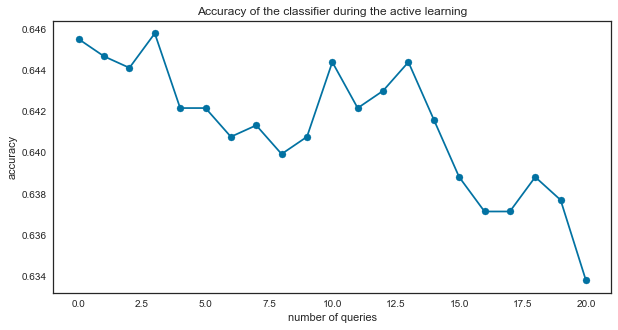

In [22]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

In [50]:
# query_idx, query_sample = learner.query(X_train_pool, n_instances = 5) # Need to update vader sentiment to work with list.

In [57]:
# new_label = vader_sentiment_labels(query_sample)

In [60]:
# learner.teach(X = X_train_pool[query_idx], y = np.array(vader_sentiment_labels(query_sample)))

In [23]:
# Get labels for unlabeled instances

predictions = learner.predict(X_train)

In [24]:
import scipy.sparse
scipy.sparse.save_npz('./data/X_sparse.npz', X_train)
np.save('./data/y_sparse.npy', predictions)

In [39]:
print("X:", X_train.shape[0], "- y:", len(predictions))

X: 179544 - y: 179544
